In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sys.path.append('../')

from lychee import lychee
from empirical import empirical
from miller import miller

In [2]:
# reliable time resolution: 10 ** -5 seconds
time_resolution = -5

1000 samples


,label,time
0,same,0.13611
1,same,0.13620
2,same,0.13611
3,same,0.13600
4,same,0.13607


num (same, different): 
same    500
diff    500
Name: label, dtype: int64
146 unique times


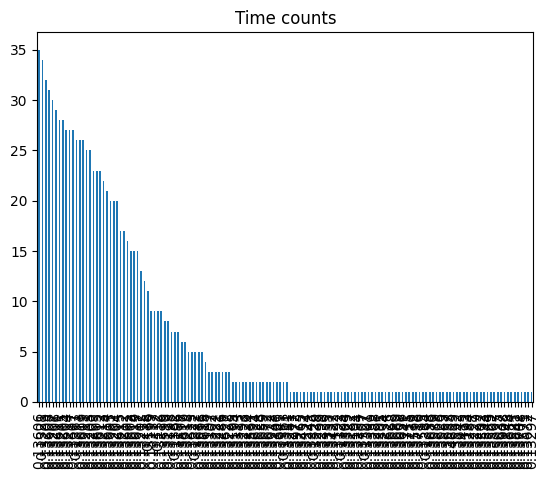

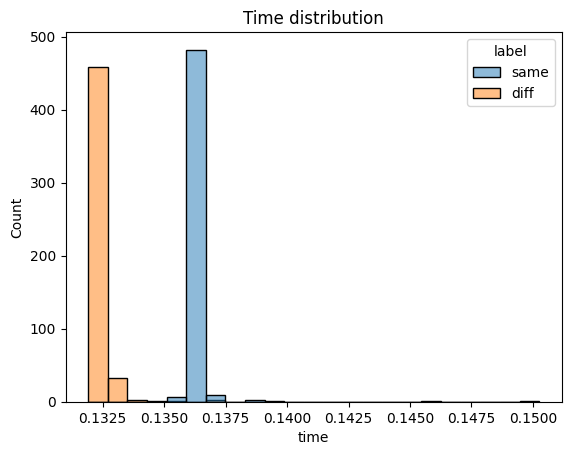

same dist:  (0.13614826, 0.0005092594352586903)
different dist:  (0.13224786, 0.0009909938548749934)


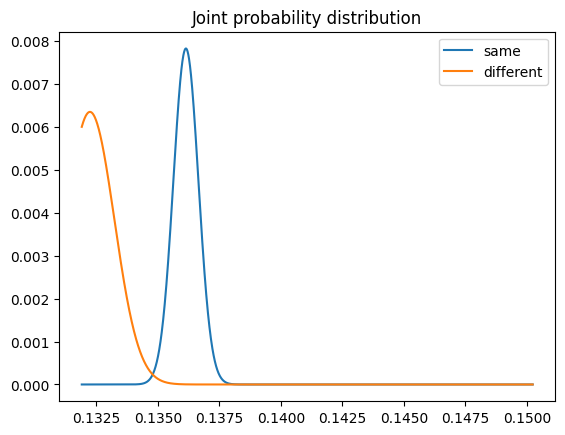

MI ground truth:  0.9738404160516628


In [3]:
data_path = "../data-epassport/raw-time-data/timesGerman500NoFix.txt"
# data_path = "../data-epassport/raw-time-data/timesGerman500FixMedian.txt"
# data_path = "../data-epassport/raw-time-data/timesBritish1000NoFix.txt"
# data_path = "../data-epassport/raw-time-data/timesBritish1000FixMedian.txt"
# data_path = "../data-epassport/raw-time-data/timesIrish500NoFix.txt"
# data_path = "../data-epassport/raw-time-data/timesIrish500FixMedian.txt"

data = []
with open(data_path, "r") as f:
    for line in f:
        dat = line.strip().strip("()").split(", ")
        dat = (dat[0], float(dat[1]))
        data.append(dat)
data = pd.DataFrame(data, columns=["label", "time"])
# round to the nearest time_resolution
data["time"] = np.round(data["time"], -time_resolution)
print(f"{len(data)} samples")
display(data.head())
print("num (same, different): ")
print(data["label"].value_counts())
print(f"{data['time'].unique().size} unique times")
# display the count of each unique time
time_cnts = data["time"].value_counts()
fig, ax = plt.subplots()
time_cnts.plot(ax=ax, kind="bar")
ax.set_title("Time counts")
plt.show()
# display the distribution of times for same and different
fig, ax = plt.subplots()
sns.histplot(data, x="time", hue="label", ax=ax)
ax.set_title("Time distribution")
plt.show()

# get the gaussian distribution for same and different
same = data[data["label"] == "same"]
different = data[data["label"] == "diff"]
same_dist = norm.fit(same["time"])
different_dist = norm.fit(different["time"])
print("same dist: ", same_dist)
print("different dist: ", different_dist)
# get the discretized joint probability distribution
times = (
    np.arange(
        int(data["time"].min() * 10**-time_resolution),
        int(data["time"].max() * 10**-time_resolution + 1),
        1,
    )
    * 10**time_resolution
)
t0 = times[:-1]
t1 = times[1:]
# probability = cdf(t1) - cdf(t0)
p_same = norm.cdf(t1, *same_dist) - norm.cdf(t0, *same_dist)
p_same = p_same / np.sum(p_same)
p_diff = norm.cdf(t1, *different_dist) - norm.cdf(t0, *different_dist)
p_diff = p_diff / np.sum(p_diff)
# display the joint probability distribution
fig, ax = plt.subplots()
ax.plot(t0, p_same, label="same")
ax.plot(t0, p_diff, label="different")
ax.set_title("Joint probability distribution")
plt.legend()
plt.show()
# compute the mutual information
pxy = np.array([p_same, p_diff])
pxy = pxy / np.sum(pxy)
assert np.isclose(np.sum(pxy), 1.0)
mi_ground_truth = empirical(pxy)
print("MI ground truth: ", mi_ground_truth)

# Sample analysis

In [5]:
joint_space_size = 2 * len(t0)
sample_sizes = (np.array([0.5, 1, 2, 5]) * joint_space_size).astype(int)
print(f"len(t0): {len(t0)}, joint_space_size: {joint_space_size}")
print(f"sample sizes: {sample_sizes}")
trials = 30
result = []
for sample_size in sample_sizes:
    sample_size_per_label = sample_size // 2
    for t_idx in range(trials):
        print(f"sample size: {sample_size}, trial: {t_idx}", end="\r")
        time_same_sample = np.random.choice(t0, sample_size, p=p_same)
        time_diff_sample = np.random.choice(t0, sample_size, p=p_diff)
        time_same_sample_cnts = np.unique(time_same_sample, return_counts=True)
        time_same_sample_cnts = dict(
            zip(time_same_sample_cnts[0], time_same_sample_cnts[1])
        )
        time_diff_sample_cnts = np.unique(time_diff_sample, return_counts=True)
        time_diff_sample_cnts = dict(
            zip(time_diff_sample_cnts[0], time_diff_sample_cnts[1])
        )
        sample_xy_empirical = np.zeros((2, len(t0)))
        for i, t in enumerate(t0):
            sample_xy_empirical[0, i] = time_same_sample_cnts.get(t, 0)
            sample_xy_empirical[1, i] = time_diff_sample_cnts.get(t, 0)
        mi_empirical = empirical(sample_xy_empirical)
        mi_miller = miller(sample_xy_empirical, sample_size)
        mi_chao = lychee(
            sample_xy_empirical, is_flat=False, is_adjust=True, is_muller=True
        )
        result.append(
            {
                "sample_size": sample_size,
                "trial": t_idx,
                "mi_empirical": mi_empirical,
                "mi_miller": mi_miller,
                "mi_chao": mi_chao,
            }
        )
result = pd.DataFrame(result)

len(t0): 1834, joint_space_size: 3668
sample sizes: [ 1834  3668  7336 18340]


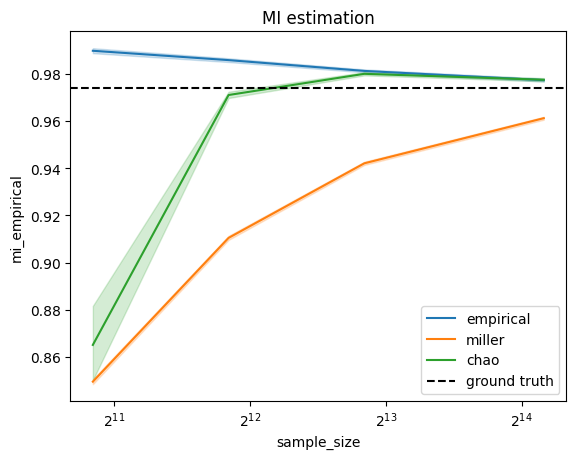

In [6]:
fig, ax = plt.subplots()
sns.lineplot(
    data=result, x="sample_size", y="mi_empirical", ax=ax, label="empirical"
)
sns.lineplot(data=result, x="sample_size", y="mi_miller", ax=ax, label="miller")
sns.lineplot(data=result, x="sample_size", y="mi_chao", ax=ax, label="chao")
ax.axhline(mi_ground_truth, color="black", linestyle="--", label="ground truth")
ax.set_title("MI estimation")
ax.set_xscale("log", base=2)
plt.legend()
plt.show()

all

In [7]:
name_path = {
    "German500NoFix": "../data-epassport/raw-time-data/timesGerman500NoFix.txt",
    "German500Fix": "../data-epassport/raw-time-data/timesGerman500FixMedian.txt",
    "British1000NoFix": "../data-epassport/raw-time-data/timesBritish1000NoFix.txt",
    "British1000Fix": "../data-epassport/raw-time-data/timesBritish1000FixMedian.txt",
    "Irish500NoFix": "../data-epassport/raw-time-data/timesIrish500NoFix.txt",
    "Irish500Fix": "../data-epassport/raw-time-data/timesIrish500FixMedian.txt",
}

for name, data_path in name_path.items():
    data = []
    with open(data_path, "r") as f:
        for line in f:
            dat = line.strip().strip("()").split(", ")
            dat = (dat[0], float(dat[1]))
            data.append(dat)
    data = pd.DataFrame(data, columns=["label", "time"])
    data["time"] = np.round(data["time"], -time_resolution)
    same = data[data["label"] == "same"]
    different = data[data["label"] == "diff"]
    same_dist = norm.fit(same["time"])
    different_dist = norm.fit(different["time"])
    times = (
        np.arange(
            int(data["time"].min() * 10**-time_resolution),
            int(data["time"].max() * 10**-time_resolution + 1),
            1,
        )
        * 10**time_resolution
    )
    t0 = times[:-1]
    t1 = times[1:]
    p_same = norm.cdf(t1, *same_dist) - norm.cdf(t0, *same_dist)
    p_same = p_same / np.sum(p_same)
    p_diff = norm.cdf(t1, *different_dist) - norm.cdf(t0, *different_dist)
    p_diff = p_diff / np.sum(p_diff)
    pxy = np.array([p_same, p_diff])
    pxy = pxy / np.sum(pxy)
    assert np.isclose(np.sum(pxy), 1.0)
    mi_ground_truth = empirical(pxy)

    joint_space_size = 2 * len(t0)
    print(
        f"{name=}, joint_space_size: {joint_space_size}, mi_ground_truth: {mi_ground_truth}"
    )

name='German500NoFix', joint_space_size: 3668, mi_ground_truth: 0.9738404160516628
name='German500Fix', joint_space_size: 3712, mi_ground_truth: 0.11149720998679902
name='British1000NoFix', joint_space_size: 2874, mi_ground_truth: 0.9724058306811061
name='British1000Fix', joint_space_size: 2406, mi_ground_truth: 0.013301709985768184
name='Irish500NoFix', joint_space_size: 3870, mi_ground_truth: 0.9999970019837832
name='Irish500Fix', joint_space_size: 2864, mi_ground_truth: 0.37243177915558345


Processing German500NoFix...
Processing German500Fix...
Processing British1000NoFix...
Processing British1000Fix...
Processing Irish500NoFix...
Processing Irish500Fix...


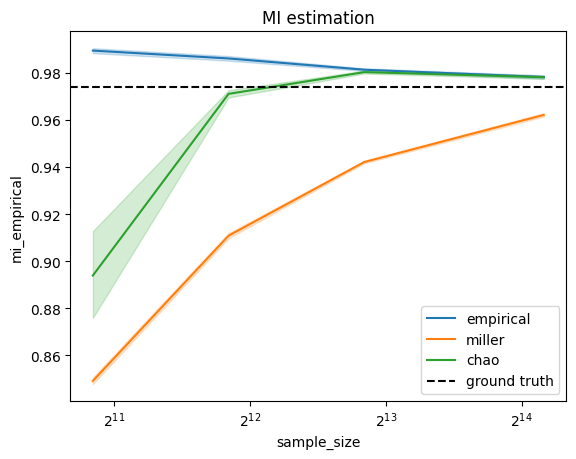

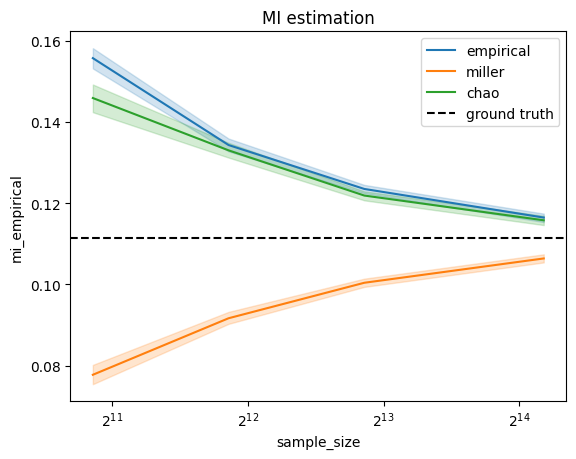

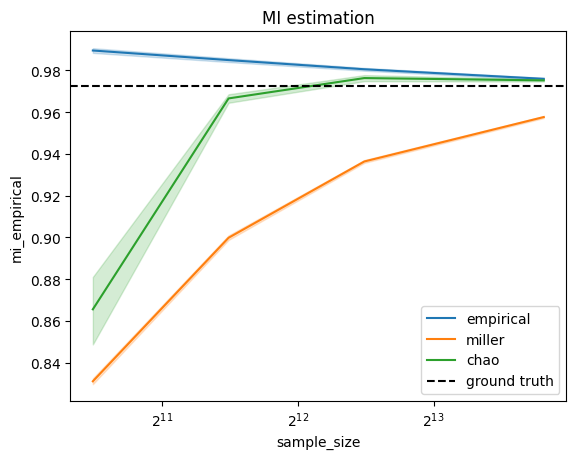

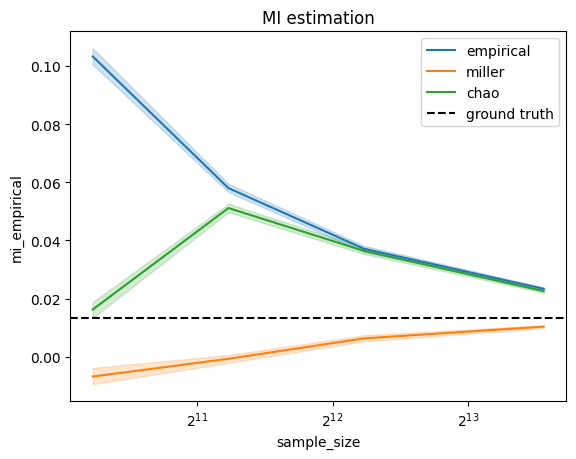

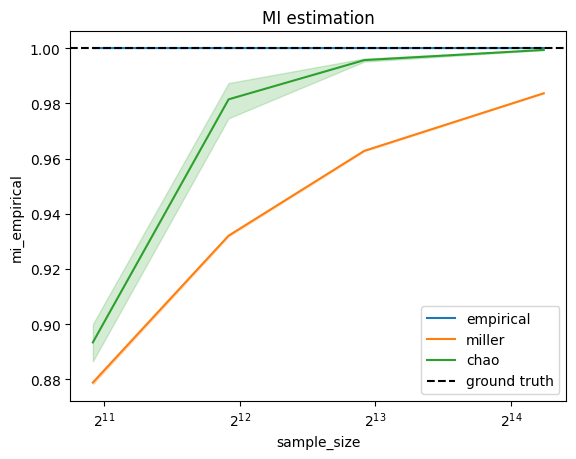

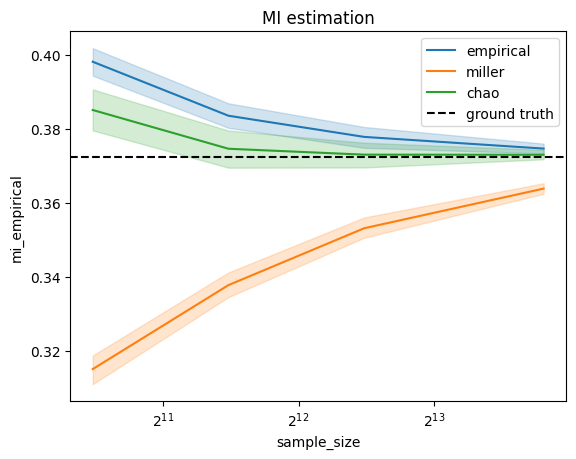

In [6]:
name_path = {
    "German500NoFix": "../data-epassport/raw-time-data/timesGerman500NoFix.txt",
    "German500Fix": "../data-epassport/raw-time-data/timesGerman500FixMedian.txt",
    "British1000NoFix": "../data-epassport/raw-time-data/timesBritish1000NoFix.txt",
    "British1000Fix": "../data-epassport/raw-time-data/timesBritish1000FixMedian.txt",
    "Irish500NoFix": "../data-epassport/raw-time-data/timesIrish500NoFix.txt",
    "Irish500Fix": "../data-epassport/raw-time-data/timesIrish500FixMedian.txt",
}

for name, data_path in name_path.items():
    print(f"Processing {name}...")
    data = []
    with open(data_path, "r") as f:
        for line in f:
            dat = line.strip().strip("()").split(", ")
            dat = (dat[0], float(dat[1]))
            data.append(dat)
    data = pd.DataFrame(data, columns=["label", "time"])
    # round to the nearest time_resolution
    data["time"] = np.round(data["time"], -time_resolution)

    # get the gaussian distribution for same and different
    same = data[data["label"] == "same"]
    different = data[data["label"] == "diff"]
    same_dist = norm.fit(same["time"])
    different_dist = norm.fit(different["time"])
    # get the discretized joint probability distribution
    times = (
        np.arange(
            int(data["time"].min() * 10**-time_resolution),
            int(data["time"].max() * 10**-time_resolution + 1),
            1,
        )
        * 10**time_resolution
    )
    t0 = times[:-1]
    t1 = times[1:]
    # probability = cdf(t1) - cdf(t0)
    p_same = norm.cdf(t1, *same_dist) - norm.cdf(t0, *same_dist)
    p_same = p_same / np.sum(p_same)
    p_diff = norm.cdf(t1, *different_dist) - norm.cdf(t0, *different_dist)
    p_diff = p_diff / np.sum(p_diff)
    # compute the mutual information
    pxy = np.array([p_same, p_diff])
    pxy = pxy / np.sum(pxy)
    assert np.isclose(np.sum(pxy), 1.0)
    mi_ground_truth = empirical(pxy)
    # print("MI ground truth: ", mi_ground_truth)

    joint_space_size = 2 * len(t0)
    sample_sizes = (np.array([0.5, 1, 2, 5]) * joint_space_size).astype(int)

    trials = 30
    result = []
    for sample_size in sample_sizes:
        sample_size_per_label = sample_size // 2
        for t_idx in range(trials):
            time_same_sample = np.random.choice(t0, sample_size, p=p_same)
            time_diff_sample = np.random.choice(t0, sample_size, p=p_diff)
            time_same_sample_cnts = np.unique(
                time_same_sample, return_counts=True
            )
            time_same_sample_cnts = dict(
                zip(time_same_sample_cnts[0], time_same_sample_cnts[1])
            )
            time_diff_sample_cnts = np.unique(
                time_diff_sample, return_counts=True
            )
            time_diff_sample_cnts = dict(
                zip(time_diff_sample_cnts[0], time_diff_sample_cnts[1])
            )
            sample_xy_empirical = np.zeros((2, len(t0)))
            for i, t in enumerate(t0):
                sample_xy_empirical[0, i] = time_same_sample_cnts.get(t, 0)
                sample_xy_empirical[1, i] = time_diff_sample_cnts.get(t, 0)
            mi_empirical = empirical(sample_xy_empirical)
            mi_miller = miller(sample_xy_empirical, sample_size)
            mi_chao = lychee(
                sample_xy_empirical,
                is_flat=False,
                is_adjust=True,
                is_muller=True,
            )
            result.append(
                {
                    "sample_size": sample_size,
                    "trial": t_idx,
                    "mi_empirical": mi_empirical,
                    "mi_miller": mi_miller,
                    "mi_chao": mi_chao,
                }
            )
    result = pd.DataFrame(result)
    save_path = f"../data-epassport/estimate/{name}.csv"
    result.to_csv(save_path, index=False)
